In [1]:
!pip install torch_geometric

In [2]:
!pip install captum

In [81]:
import torch
from torch.nn import ReLU, LogSoftmax
from torch.nn.functional import nll_loss
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import Planetoid

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root="./data/cora", name="cora")
data = dataset[0].to(device)

Processing...
Done!


In [110]:
dataset.num_features

1433

In [112]:
from torch_geometric.nn import GATConv, GCNConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8)
        self.conv2 = GATConv(64, dataset.num_classes, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'Training acc: {acc_train:.2f}, test acc: {acc_test:.2f}')

Training acc: 1.00, test acc: 0.79


In [101]:
torch.save(model.state_dict(), './cora_gat.pt')

In [92]:
model.eval()

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)

In [ ]:
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [ ]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import AttentionExplainer

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, GraphMaskExplainer, CaptumExplainer, metric

In [ ]:
from torch_geometric.explain import Explainer, CaptumExplainer, metric
from fidelity.fidelity import fidelity
import numpy as np
import copy
import json

n_idxs = 50
n_runs = 5
nodes_idxs = torch.randperm(data.num_nodes)[:n_idxs]
topk = [5, 10, 15, 20, 50, 100]

explainer_names = ['AttentionExplainer', 'Saliency', 'InputXGradient', 'GNNExplainer', 'PGExplainer', 'GraphMaskExplainer' ]
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']
results = []

In [ ]:
for _ in range(n_runs):
  run_results = {e: {m: [] for m in metric_names } for e in explainer_names}
  for i in range(len(topk)):

    topk_val = topk[i]
    explained_model = copy.deepcopy(model)
    fid = {'+': np.zeros(n_idxs), '-': np.zeros(n_idxs)}
    fls = np.zeros(n_idxs)

    #Attention explainer
    att_exp = Explainer(
        model=model,
        algorithm=AttentionExplainer(),
        explanation_type='model',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
        threshold_config=dict(threshold_type='topk', value=topk_val),
    )

    # GNNExplainer
    gnn_exp = Explainer(
        model=explained_model,
        algorithm=GNNExplainer(epochs=200).to(device),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
        threshold_config=dict(threshold_type='topk', value=topk_val),
    )

    # PGExplainer
    pg_exp = Explainer(
        model=explained_model,
        algorithm=PGExplainer(epochs=1, lr=0.001).to(device),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
        threshold_config=dict(threshold_type='topk', value=topk_val),
    )

    for epoch in range(1):
        for index in range(data.num_nodes):
            pg_exp.algorithm.train(epoch, explained_model, data.x, data.edge_index, target=data.y, index=index)

    # GraphMaskExplainer
    gm_exp = Explainer(
        model=explained_model,
        algorithm=GraphMaskExplainer(2, epochs=10).to(device),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
        threshold_config=dict(threshold_type='topk', value=topk_val),
    )

    # Saliency
    sal_exp = Explainer(
        model=explained_model,
        algorithm=CaptumExplainer('Saliency').to(device),
        explanation_type='phenomenon',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
        edge_mask_type='object',
        threshold_config=dict(threshold_type='topk', value=topk_val),
    )

    # Input X Gradient
    ixg_exp = Explainer(
        model=explained_model,
        algorithm=CaptumExplainer('InputXGradient').to(device),
        explanation_type='phenomenon',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
        edge_mask_type='object',
        threshold_config=dict(threshold_type='topk', value=topk_val),
    )


    # Gradient methods have to be first in the list
    explainers = { 'AttentionExplainer': att_exp, 'Saliency': sal_exp, 'InputXGradient': ixg_exp , 'GNNExplainer': gnn_exp, 'PGExplainer': pg_exp, 'GraphMaskExplainer': gm_exp}
    for name, explainer in explainers.items():
        for j in range(n_idxs):
            node_index = nodes_idxs[j].item()
            explanation = explainer(data.x, data.edge_index, index=node_index, target=data.y)
            fid['+'][j], fid['-'][j] = fidelity(explainer, explanation)
            fls[j] = metric.unfaithfulness(explainer, explanation)

        run_results[name]['Fidelity+'].append(fid['+'].mean())
        run_results[name]['Fidelity-'].append(fid['-'].mean())
        # Replace 0 with 0.001 in fidelity+ to avoid division by zero
        fid['+'][fid['+'] == 0] = 0.001
        # Replace 1 with 0.999 in fidelity- to avoid division by zero
        fid['-'][fid['-'] == 1] = 0.999
        run_results[name]['Characterization score'].append(metric.characterization_score(fid['+'].mean(), fid['-'].mean(), pos_weight=0.5, neg_weight=0.5))
        run_results[name]['Unfaithfulness'].append(fls.mean())
  results.append(run_results)

agg_results = {e: {m: [0] * len(topk) for m in metric_names } for e in explainer_names}
for r in results:
    for e in explainer_names:
        for m in metric_names:
            for i in range(len(topk)):
                agg_results[e][m][i] += r[e][m][i] / n_runs

json.dump(agg_results, open('./CORA_gat_results.json', 'w'))

/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py:192: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
Train explainer for node(s) tensor([2646]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 26.20it/s]
Train explainer for node(s) tensor([2646]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 41.83it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 192.39it/s]
Train explainer for node(s) tensor([1862]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 72.64it/s]
Train explainer for node(s) tensor([1862]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 60.61it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 271.48it/s]
Train explainer for node(s) tensor([1872]) with layer 1: 100%|██████████| 10/10 [00:00<00:00, 67.61it/s]
Train explainer for node(s) tensor([1872]) with layer 0: 100%|██████████| 10/10 [00:00<00:00, 57.95it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 186.62it/s]
Train explainer for n

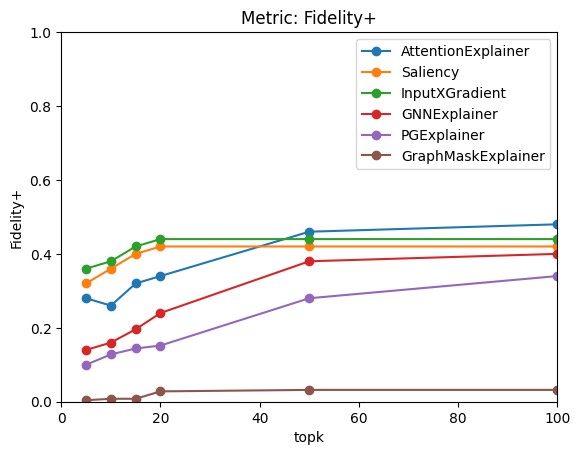

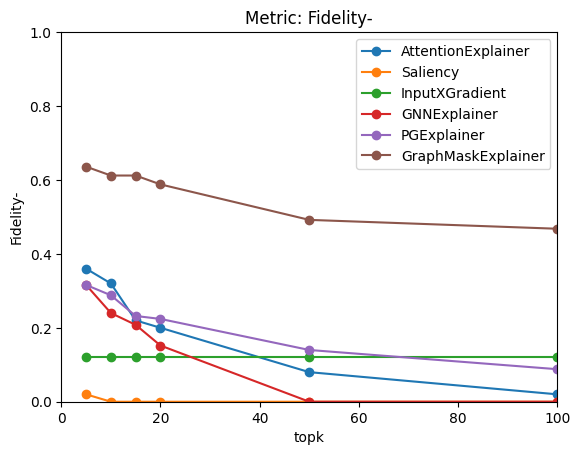

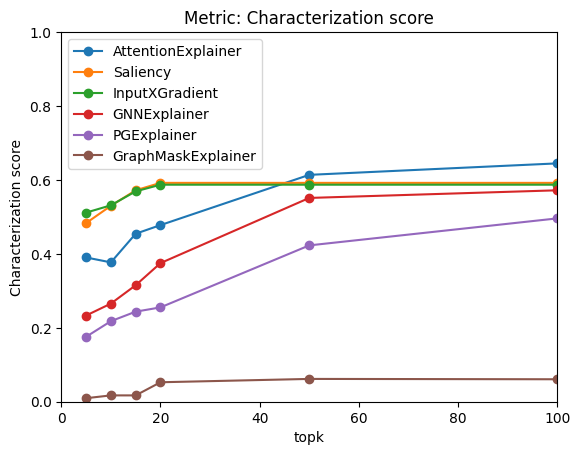

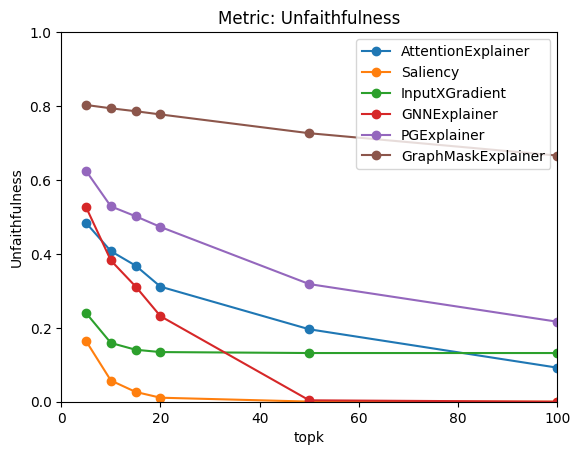

In [ ]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./CORA_gat_results.json', 'r'))

for m in metric_names:
    plt.figure()
    for e in explainer_names:
        plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()

# MNIST SuperPixel GAT

In [3]:
from torch_geometric.datasets import MNISTSuperpixels
train_dataset = MNISTSuperpixels(root='./data/mnistsuperpixel', train=True)
test_dataset = MNISTSuperpixels(root='./data/mnistsuperpixel', train=False)

Extracting data/mnistsuperpixel/raw/MNISTSuperpixels.zip
Processing...
Done!


In [4]:
import torch
from torch.nn import ReLU, Linear, LogSoftmax
from torch.nn.functional import cross_entropy
from torch_geometric.nn import Sequential, GATConv, global_add_pool, global_mean_pool, BatchNorm
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = MNISTSuperpixels(root='./data/mnistsuperpixel', train=True)
test_dataset = MNISTSuperpixels(root='./data/mnistsuperpixel', train=False)

BATCH_SIZE = 64
TRAIN_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

hidden_channels = 146
num_heads = 8  # You can adjust this value based on your needs

model = Sequential("x, edge_index, batch", [
    (Linear(train_dataset.num_features, hidden_channels), "x -> x"),
    (GATConv(hidden_channels, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (global_add_pool, "x, batch -> x"),
    (Linear(hidden_channels * num_heads, train_dataset.num_classes), "x -> x"),
]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, min_lr=1e-5)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

In [ ]:
print(model)

Sequential(
  (0) - Linear(in_features=1, out_features=146, bias=True): x -> x
  (1) - GATConv(146, 146, heads=8): x, edge_index -> x
  (2) - BatchNorm(1168): x -> x
  (3) - ReLU(inplace=True): x -> x
  (4) - GATConv(1168, 146, heads=8): x, edge_index -> x
  (5) - BatchNorm(1168): x -> x
  (6) - ReLU(inplace=True): x -> x
  (7) - GATConv(1168, 146, heads=8): x, edge_index -> x
  (8) - BatchNorm(1168): x -> x
  (9) - ReLU(inplace=True): x -> x
  (10) - GATConv(1168, 146, heads=8): x, edge_index -> x
  (11) - BatchNorm(1168): x -> x
  (12) - ReLU(inplace=True): x -> x
  (13) - <function global_add_pool at 0x7c6aa7016170>: x, batch -> x
  (14) - Linear(in_features=1168, out_features=10, bias=True): x -> x
)


In [ ]:
for i in range(1, 21):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
    train_acc = test(train_loader)
    scheduler.step(train_acc)
    if i % 10 == 0:
        print(f'Epoch: {i:03d}, Train: {train_acc:.4f}')

torch.save(model.state_dict(), './mnist_superpixels_gat.pt')

Epoch: 010, Train: 0.6270
Epoch: 020, Train: 0.6902


In [ ]:
def evaluate(loader, model):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.y.size(0)
    accuracy = correct / total
    return accuracy

# After training loop
train_accuracy = evaluate(train_loader, model)
test_accuracy = evaluate(test_loader, model)

print(f'Training accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')


Training accuracy: 0.6902, Test accuracy: 0.6347


In [5]:
state_dict = torch.load('./mnist_superpixels_gat_20ep.pt')

In [60]:
model = Sequential("x, edge_index", [
    (Linear(train_dataset.num_features, hidden_channels), "x -> x"),
    (GATConv(hidden_channels, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels * num_heads), "x -> x"),
    ReLU(inplace=True),
    (global_add_pool, "x, None -> x"),
    (Linear(hidden_channels * num_heads, train_dataset.num_classes), "x -> x"),
]).to(device)

In [61]:
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [71]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=35ca4265ca90a215c74abc90d0d635c127fb9ce2cf8b8242368f7a43d03cfe45
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [78]:
import torch_geometric

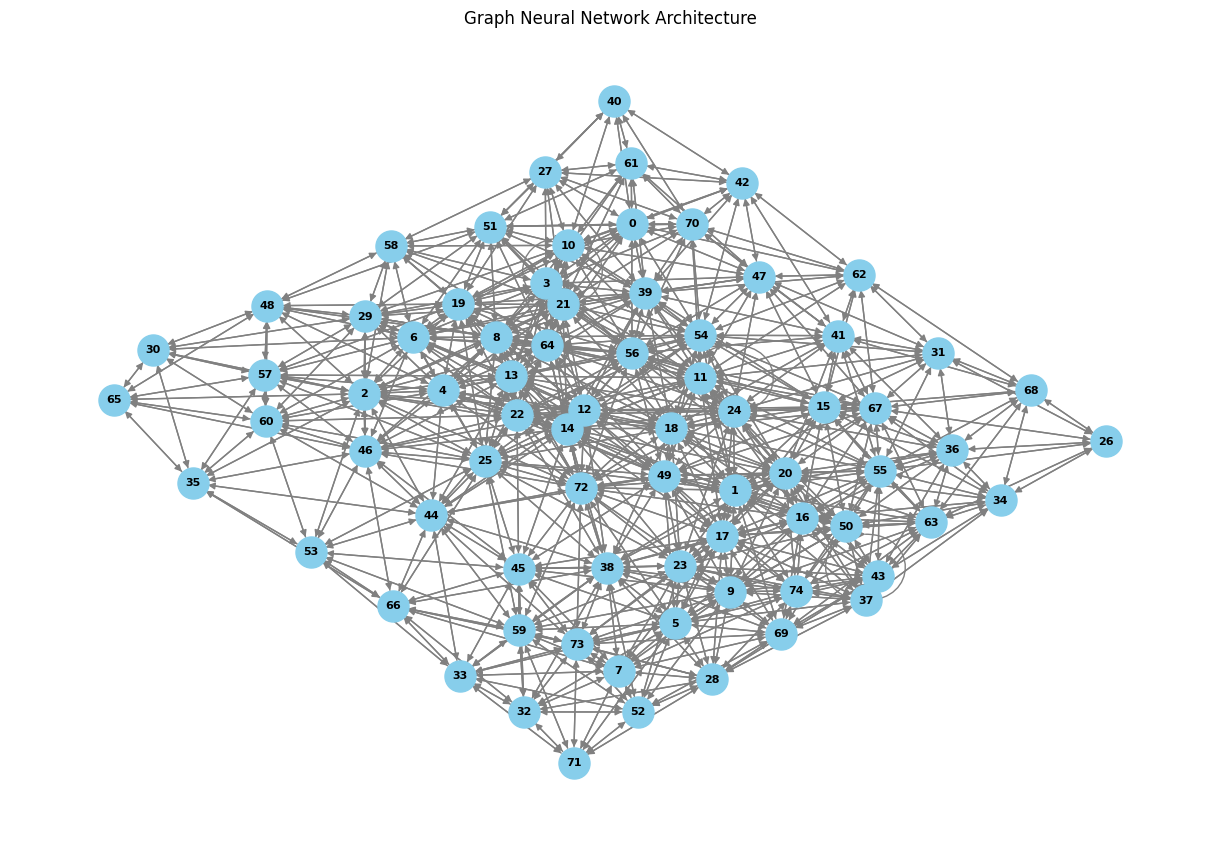

In [80]:

# Dummy input
x = sample_data.x.unsqueeze(0).to(device)
edge_index = sample_data.edge_index.to(device)

# Create a NetworkX graph for visualization
pyg_graph = torch_geometric.utils.to_networkx(sample_data)

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(pyg_graph)  # You can choose a different layout if needed
nx.draw(pyg_graph, pos, with_labels=True, font_weight='bold', node_size=500, node_color='skyblue', font_size=8, edge_color='gray')
plt.title("Graph Neural Network Architecture")
plt.show()

In [ ]:
def evaluate(loader, model):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.y.size(0)
    accuracy = correct / total
    return accuracy

# After training loop
train_accuracy = evaluate(train_dataset, model)
test_accuracy = evaluate(test_dataset, model)

print(f'Training accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')


Training accuracy: 0.0987, Test accuracy: 0.0980


In [8]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import AttentionExplainer

In [ ]:
agg_results=None

In [52]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, CaptumExplainer, metric
from fidelity.fidelity import fidelity
import numpy as np
import copy
import json

train_idx = torch.randperm(len(train_dataset))[:TRAIN_SIZE]

n_idxs = 50
n_runs = 5
graph_idxs = torch.randperm(len(test_dataset))[:n_idxs]
topk = [5, 10, 15, 20, 50, 100]

explainer_names = ['GNNExplainer', 'PGExplainer','Saliency', 'InputXGradient', 'AttentionExplainer']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']
results = []
e_model = model

for _ in range(n_runs):
    run_results = {e: {m: [] for m in metric_names } for e in explainer_names}
    for i in range(len(topk)):

        topk_val = topk[i]
        explained_model = copy.deepcopy(e_model)
        fid = {'+': np.zeros(n_idxs), '-': np.zeros(n_idxs)}
        fls = np.zeros(n_idxs)

         # GNNExplainer
        gnn_exp = Explainer(
            model=explained_model,
            algorithm=GNNExplainer(epochs=200).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # PGExplainer
        pg_exp = Explainer(
            model=explained_model,
            algorithm=PGExplainer(epochs=1, lr=0.001).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        for epoch in range(1):
            for index in train_idx:
                data = train_dataset[index].to(device)
                pg_exp.algorithm.train(epoch, explained_model, data.x, data.edge_index, target=data.y)

        #Attention explainer
        att_exp = Explainer(
            model=explained_model,
            algorithm=AttentionExplainer(),
            explanation_type='model',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Saliency
        sal_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('Saliency').to(device),
            explanation_type='model',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            edge_mask_type='object',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Input X Gradient
        ixg_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('InputXGradient').to(device),
            explanation_type='model',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            edge_mask_type='object',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Gradient methods have to be first in the list
        explainers = {'Saliency': sal_exp, 'InputXGradient': ixg_exp, 'GNNExplainer': gnn_exp, 'PGExplainer': pg_exp,  'AttentionExplainer': att_exp}
        for name, explainer in explainers.items():
            for j in range(n_idxs):
                graph_index = graph_idxs[j].item()
                data = test_dataset[graph_index].to(device)
                explanation = explainer(data.x, data.edge_index, target=data.y)
                fid['+'][j], fid['-'][j] = fidelity(explainer, explanation)
                fls[j] = metric.unfaithfulness(explainer, explanation)
            run_results[name]['Fidelity+'].append(fid['+'].mean())
            run_results[name]['Fidelity-'].append(fid['-'].mean())
            # Replace 0 with 0.001 in fidelity+ to avoid division by zero
            fid['+'][fid['+'] == 0] = 0.001
            # Replace 1 with 0.999 in fidelity- to avoid division by zero
            fid['-'][fid['-'] == 1] = 0.999
            run_results[name]['Characterization score'].append(metric.characterization_score(fid['+'].mean(), fid['-'].mean(), pos_weight=0.5, neg_weight=0.5))
            run_results[name]['Unfaithfulness'].append(fls.mean())
    results.append(run_results)

agg_results = {e: {m: [0] * len(topk) for m in metric_names } for e in explainer_names}
for r in results:
    for e in explainer_names:
        for m in metric_names:
            for i in range(len(topk)):
                agg_results[e][m][i] += r[e][m][i] / n_runs

json.dump(agg_results, open('./MNISTSuperPixel_gat_results.json', 'w'))

ERROR:root:'PGExplainer' only supports phenomenon explanations got (`explanation_type=model`)


ValueError: The explanation algorithm 'PGExplainer' does not support the given explanation settings.

In [23]:
explainer_names = ['GNNExplainer', 'PGExplainer','Saliency', 'InputXGradient', 'AttentionExplainer']

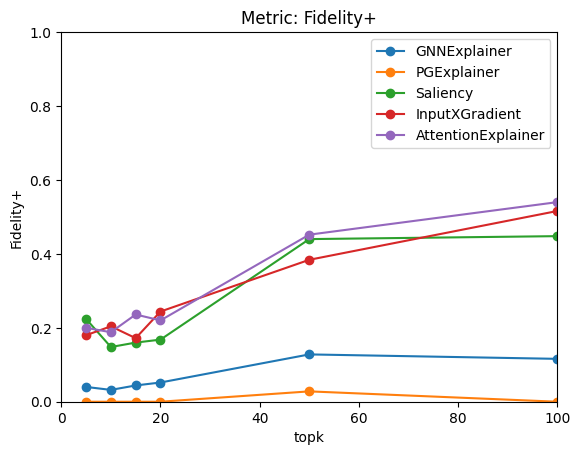

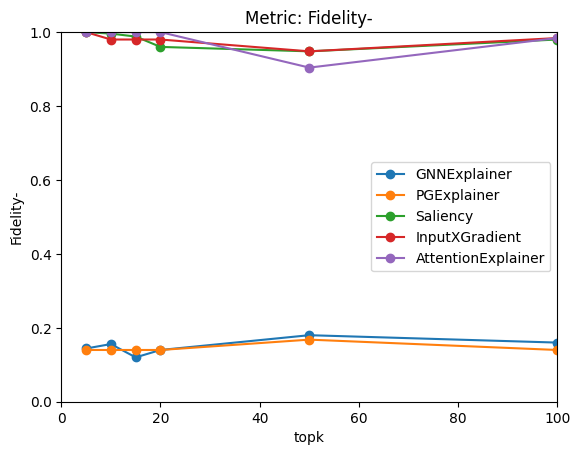

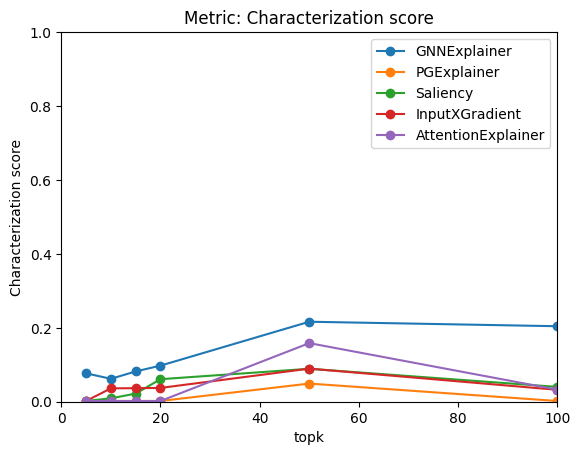

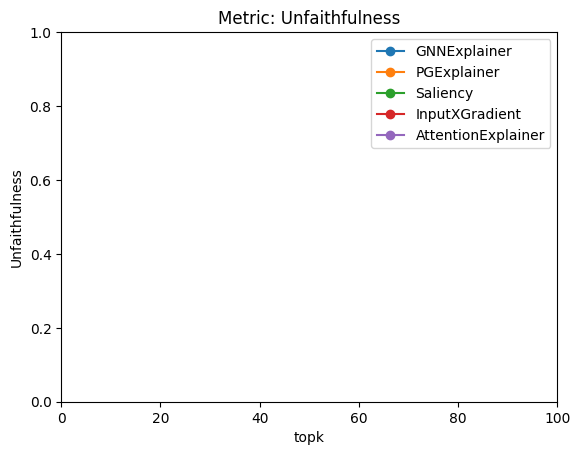

In [24]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./MNISTSuperPixel_gat_results_edge_mask.json', 'r'))

for m in metric_names:
    plt.figure()
    for e in explainer_names:
      plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()

# Plots

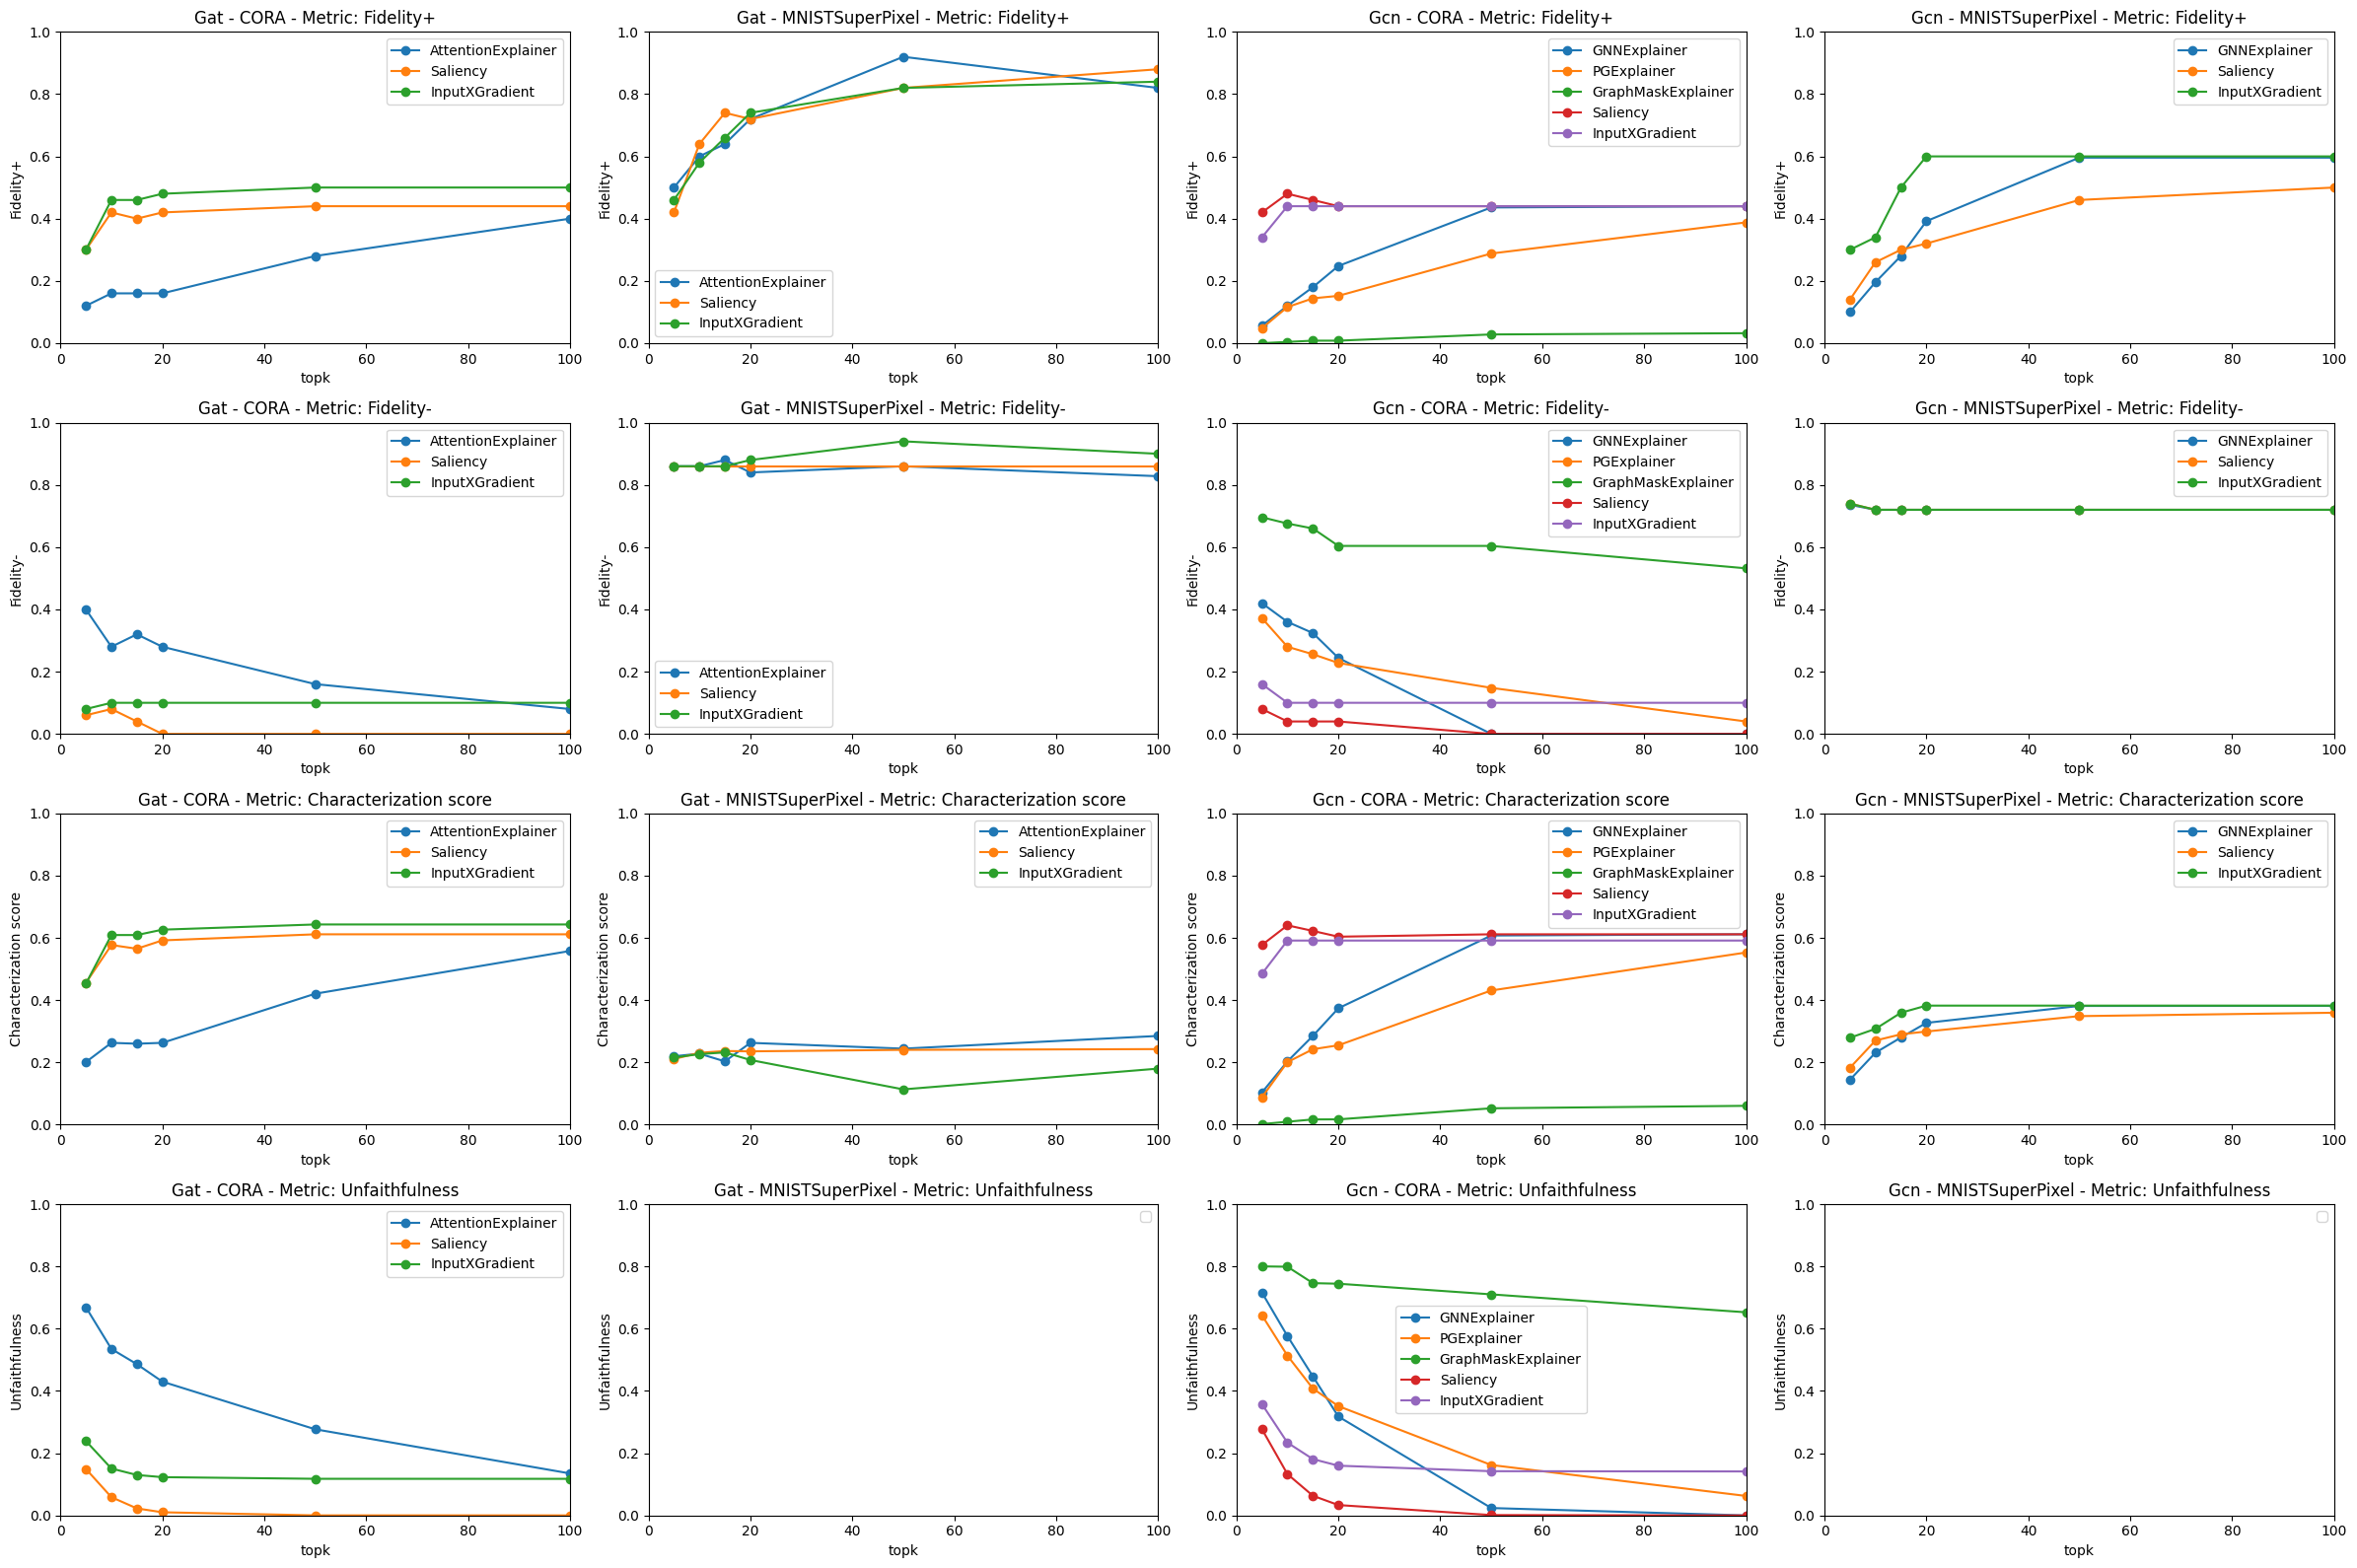

In [ ]:
import json
import matplotlib.pyplot as plt

explainer_names_gat = ['AttentionExplainer', 'Saliency', 'InputXGradient']
explainer_names_gcn_cora = ['GNNExplainer', 'PGExplainer', 'GraphMaskExplainer', 'Saliency', 'InputXGradient']
explainer_names_gcn_MNISTSuperPixel = ['GNNExplainer', 'Saliency', 'InputXGradient']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']

datasets = ['CORA', 'MNISTSuperPixel']
models = ['gat', 'gcn']

fig, axes = plt.subplots(len(metric_names), len(datasets) * len(models), figsize=(12 * len(datasets), 4 * len(metric_names)))

for i, metric in enumerate(metric_names):
    for j, model in enumerate(models):
        for k, dataset in enumerate(datasets):
            agg_results = json.load(open(f'./{dataset}_{model}_results.json', 'r'))

            explainer_names = explainer_names_gat if model == 'gat' else (explainer_names_gcn_cora if dataset == 'CORA' else explainer_names_gcn_MNISTSuperPixel)

            ax = axes[i, j * len(datasets) + k]
            for e in explainer_names:
                if not (metric == 'Unfaithfulness' and dataset == 'MNISTSuperPixel'):
                    ax.plot(topk, agg_results[e][metric], marker='o', label=f'{e}')
            ax.legend()
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 100)
            ax.set_ylabel(metric)
            ax.set_xlabel('topk')
            ax.set_title(f'{model.capitalize()} - {dataset} - Metric: {metric}')

plt.tight_layout()
plt.show()


**CORA for GAT and GCN**

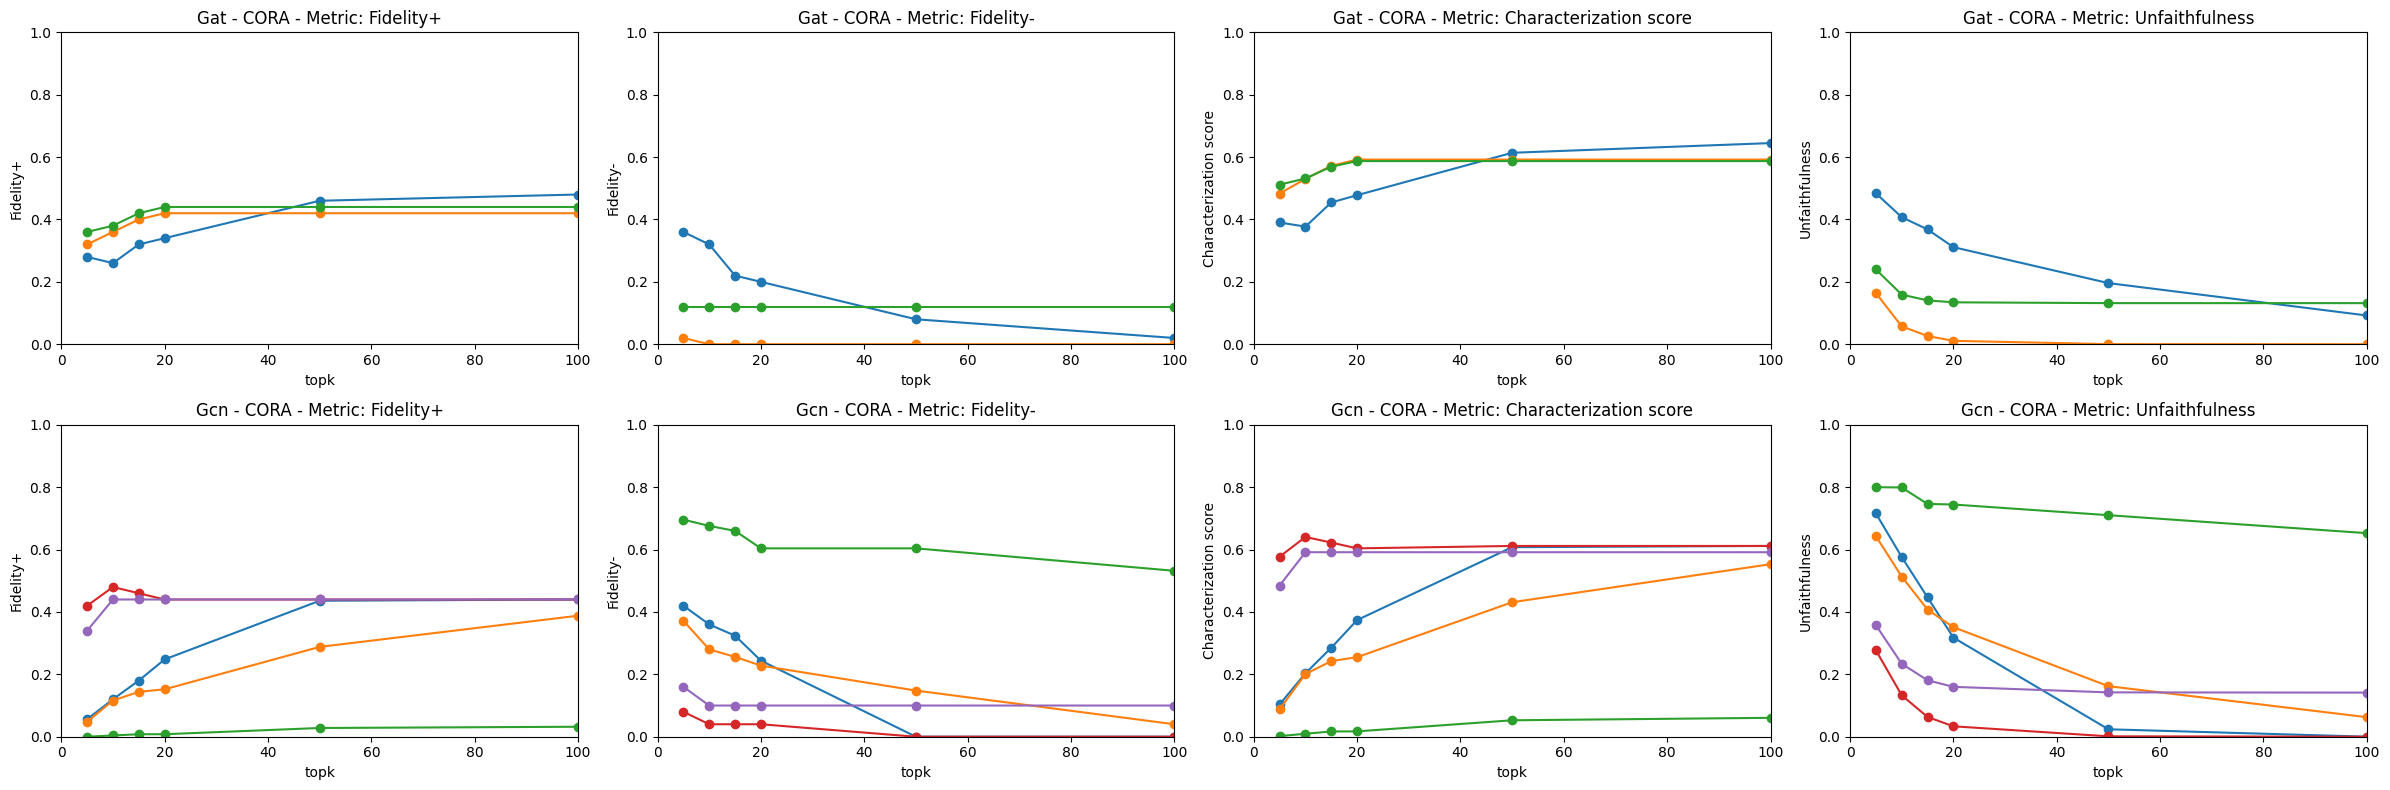

In [45]:
import json
import matplotlib.pyplot as plt

explainer_names_gat = ['AttentionExplainer', 'Saliency', 'InputXGradient']
explainer_names_gcn_cora = ['GNNExplainer', 'PGExplainer', 'GraphMaskExplainer', 'Saliency', 'InputXGradient']
explainer_names_gcn_MNISTSuperPixel = ['GNNExplainer', 'Saliency', 'InputXGradient']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']

dataset = 'CORA'
models = ['gat', 'gcn']

# Reorient the plots from 4x2 to 2x4
fig, axes = plt.subplots(2, len(metric_names), figsize=(24, 8))

for i, metric in enumerate(metric_names):
    for j, model in enumerate(models[:2]):  # Only the first two columns (CORA_gcn and CORA_gat)
            agg_results = json.load(open(f'./{dataset}_{model}_results.json', 'r'))

            explainer_names = explainer_names_gat if model == 'gat' else explainer_names_gcn_cora

            ax = axes[j, i]
            for e in explainer_names:
                if not (metric == 'Unfaithfulness' and dataset == 'MNISTSuperPixel'):
                    ax.plot(topk, agg_results[e][metric], marker='o', label=f'{e}')
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 100)
            ax.set_ylabel(metric)
            ax.set_xlabel('topk')
            ax.set_title(f'{model.capitalize()} - {dataset} - Metric: {metric}')

plt.tight_layout()
plt.show()


<ipython-input-37-9d7682be5a0d>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10')


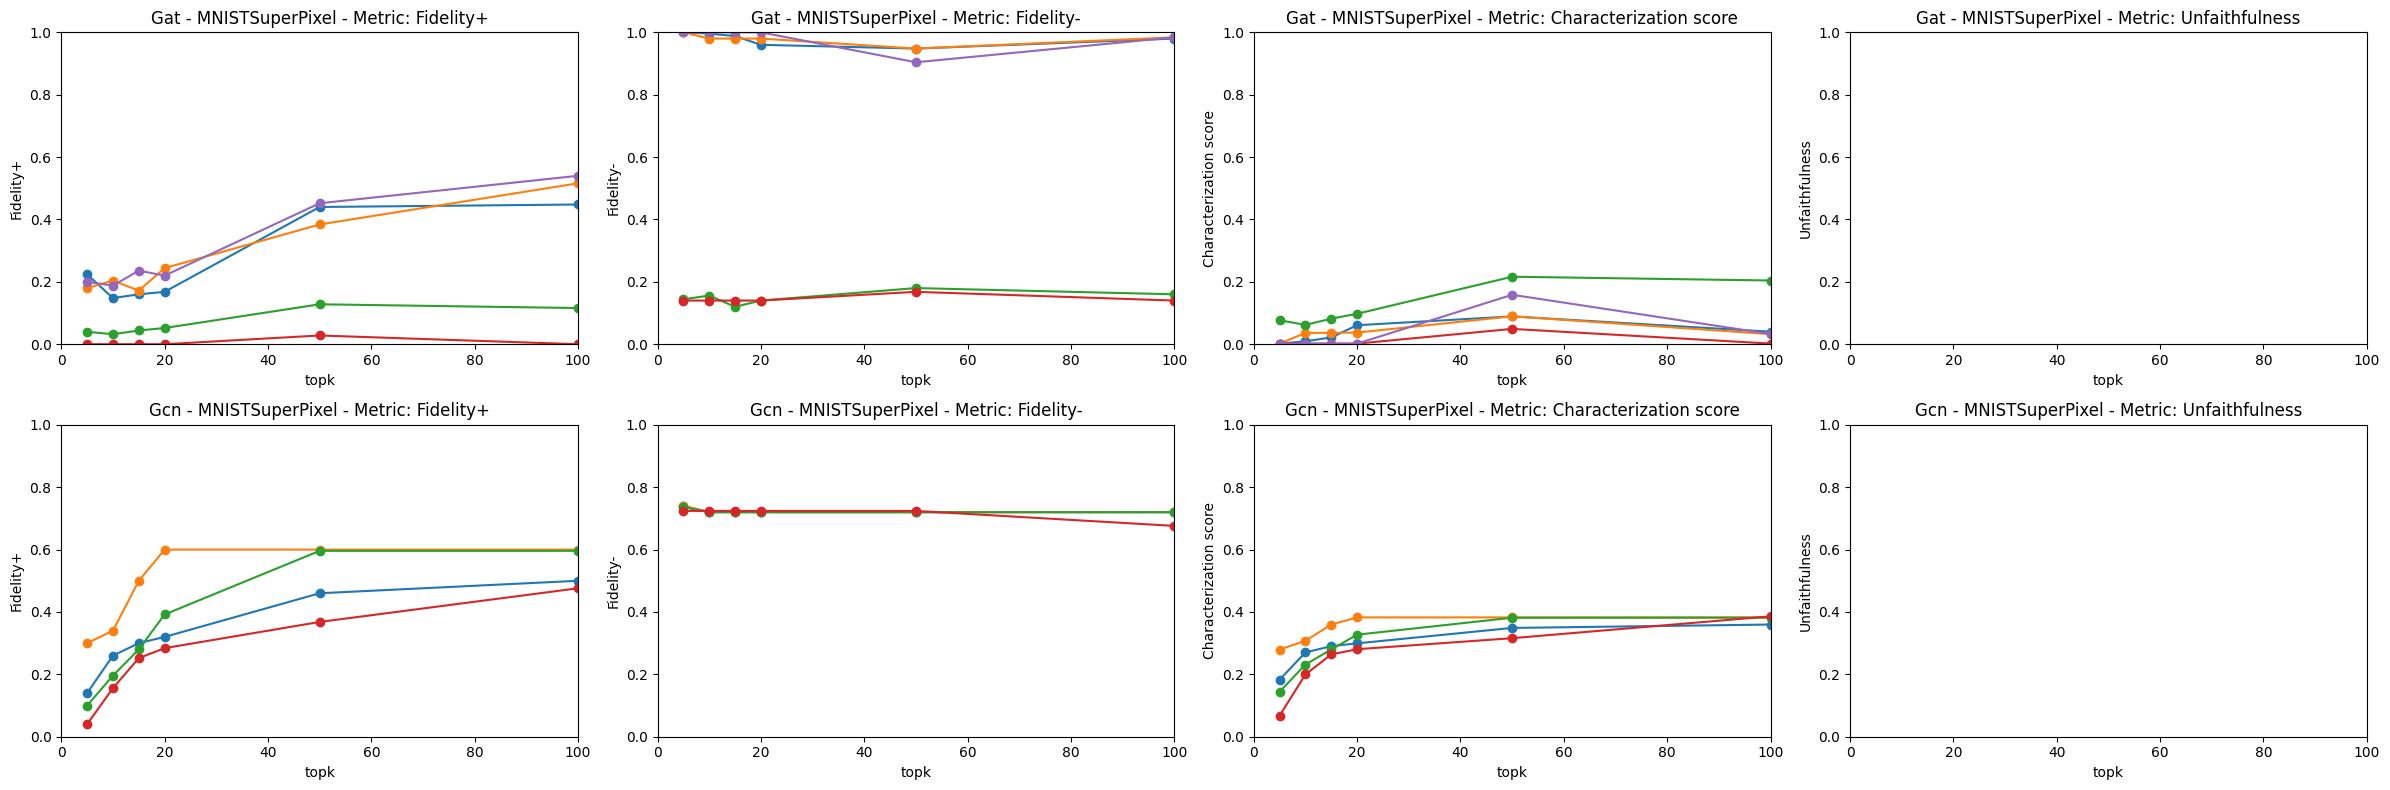

In [37]:
import json
import matplotlib.pyplot as plt

topk = [5, 10, 15, 20, 50, 100]
explainer_names_gcn_MNISTSuperPixel = ['Saliency', 'InputXGradient', 'GNNExplainer', 'PGExplainer']
explainer_names_gat_MNISTSuperPixel = ['Saliency', 'InputXGradient', 'GNNExplainer', 'PGExplainer', 'AttentionExplainer']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']

dataset = 'MNISTSuperPixel'
models = ['gat', 'gcn']

# Reorient the plots from 4x2 to 2x4
fig, axes = plt.subplots(2, len(metric_names), figsize=(24, 8))

# Define a color map for explainers
color_map = plt.cm.get_cmap('tab10')

for i, model in enumerate(models):  # Only the second row (MNISTSuperPixel)
  for k, metric in enumerate(metric_names):
      agg_results = json.load(open(f'./{dataset}_{model}_results_edge_mask.json', 'r'))

      explainer_names = explainer_names_gat_MNISTSuperPixel if model == 'gat' else explainer_names_gcn_MNISTSuperPixel

      ax = axes[i, k]
      for idx, e in enumerate(explainer_names):
          if not (metric == 'Unfaithfulness' and dataset == 'MNISTSuperPixel'):
              color = color_map(idx)
              ax.plot(topk, agg_results[e][metric], marker='o', color=color)  # Removed label
      ax.set_ylim(0, 1)
      ax.set_xlim(0, 100)
      ax.set_ylabel(metric)
      ax.set_xlabel('topk')
      ax.set_title(f'{model.capitalize()} - {dataset} - Metric: {metric}')

plt.tight_layout()
plt.show()


In [54]:
explainer_names = ['GNNExplainer', 'Saliency', 'InputXGradient']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']

IndexError: index 3 is out of bounds for axis 0 with size 3

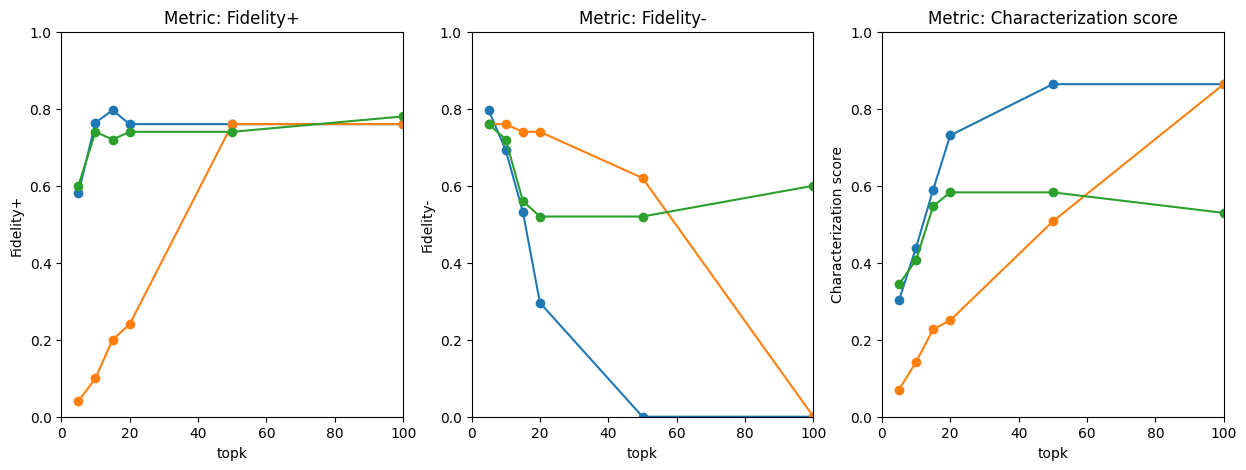

In [56]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./MNISTSuperPixel_gcn_results_node_mask.json', 'r'))

# Create one subplot with three columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, m in enumerate(metric_names):
    ax = axes[i]
    for e in explainer_names:
        ax.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
    ax.set_ylabel(m)
    ax.set_xlabel('topk')
    ax.set_title(f'Metric: {m}')

plt.tight_layout()
plt.show()
